In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
import random

# darts 관련 라이브러리
from darts import TimeSeries
from darts.models import TSMixerModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.callbacks import TFMProgressBar
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import Callback

# Random seed 고정
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

# CUDA를 사용하는 경우에도 고정 (CUDA 사용 시)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 모든 GPU에 seed 적용
    torch.backends.cudnn.deterministic = True  # 연산을 항상 동일하게 수행
    torch.backends.cudnn.benchmark = False  # 성능 저하가 있을 수 있지만 연산 일관성을 위해 비활성화

# Matplotlib 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 손실 값을 저장할 리스트
train_losses = []
val_losses = []

# Custom callback to track loss
class LossLogger(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        train_losses.append(trainer.callback_metrics["train_loss"].item())
        val_losses.append(trainer.callback_metrics["val_loss"].item())

In [3]:
# train 산지 데이터 path
sanji_path = 'data/train/meta/TRAIN_산지공판장_2018-2021.csv'
# train 도매 데이터 path
dome_path = 'data/train/meta/TRAIN_전국도매_2018-2021.csv'
# test.csv 데이터 path
test_paths = glob.glob('data/test/*.csv')

# test 산지, 도매 파일 path
test_files = glob.glob("data/test/meta/*.csv")
test_sanji_paths = []
test_dome_paths = []
for file in test_files:
    if '산지' in file:
        test_sanji_paths.append(file)
    else:
        test_dome_paths.append(file)

# test_time dictionary
test_time_dict = {'T-8순': 0,
                  'T-7순': 1,
                  'T-6순': 2,
                  'T-5순': 3,
                  'T-4순': 4,
                  'T-3순': 5,
                  'T-2순': 6,
                  'T-1순': 7,
                  'T': 8}

# 맞춰야하는 item 리스트
target_id = ['건고추_화건_30 kg_상', '사과_홍로, 후지_10 개_상', '감자_감자 수미_20키로상자_상', '배_신고_10 개_상', '깐마늘(국산)_깐마늘(국산)_20 kg_상', 
               '무_무_20키로상자_상', '상추_청_100 g_상', '배추_배추_10키로망대_상', '양파_양파_1키로_상', '대파_대파(일반)_1키로단_상']

In [4]:
def time_preprocess(data): # 시점 전처리
    data_time = dict()
    time_list = list(data['시점'].unique())
    for time in time_list:
        data_time[time] = time_list.index(time)
    data['시점'] = data['시점'].map(data_time)
    return data

def basic_preprocess_train(data, apple = False): # 기본 전처리(등급, (apple = True이면) 사과 홍로, 후지 데이터 하나로, id 생성)
    # 등급 데이터 통일
    data['등급'] = data['등급'].replace(regex = r'[품]', value = '')
    # 시점 0-143사이 숫자로 인코딩
    data = time_preprocess(data)
    # 사과 홍로, 후지 데이터 하나로
    if apple:
        data.loc[(data['품종명']=='후지') & (data['등급']=='상'), '품종명'] = '홍로, 후지'
        data.loc[(data['품종명']=='홍로') & (data['등급']=='상'), '품종명'] = '홍로, 후지'
    # id column 생성 + 제일 앞에 배치
    data['id'] = data[['품목명', '품종명', '거래단위', '등급']].agg('_'.join, axis=1)
    cols = ['id'] + [col for col in data.columns if col != 'id']
    data = data[cols]
    return data

def gen_transpose_train(data, target_id = None): # train.csv 데이터 재구성
    new_columns = {}
    for id in data['id'].unique():
        temp = data.loc[data['id'] == id, :].reset_index(drop=True)  
        # 첫 번째 조건: 평년 평균가격(원)이 0이 아닌 경우가 90% 이상이면
        if sum(temp['평년 평균가격(원)'] != 0) > 144 * 0.95:
            new_columns[f'{id}__평년 평균가격(원)'] = temp['평년 평균가격(원)']
        # 두 번째 조건: 평균가격(원)이 0이 아닌 경우가 90% 이상이면
        if sum(temp['평균가격(원)'] != 0) > 144 * 0.9:
            new_columns[f'{id}__평균가격(원)'] = temp['평균가격(원)']
    # 모든 컬럼을 한 번에 concat으로 추가
    new_data = pd.concat([pd.DataFrame(new_columns)], axis=1)
    # 맞춰야하는 item이 모두 포함되어 있는지 확인
    if target_id != None:
        new_cols = list(new_data.columns)
        for item in target_id:
            if item + '__평균가격(원)' not in new_cols:
                print(item, '이 안들어가 있습니다')
    return new_data

def gen_transpose_train_dome(dome, dome_list): # train 도매 데이터 재구성
    # 필요한 컬럼만 남기고 기본 전처리
    time_list = dome['시점'].unique()
    dome['set'] = ['도매']*len(dome)
    dome['id'] = dome[['set', '시장명', '품목명', '품종명']].agg('_'.join, axis=1)
    dome = dome.loc[dome['id'].isin(dome_list), :]
    price_cols =  ['평균가(원/kg)']
    new_columns = {}
    for id in dome['id'].unique():
        temp = dome.loc[dome['id']==id, :]
        # 전체 데이터가 90퍼센트가 이상인 id의 데이터만 사용
        if len(temp) > 144 * 0.9:
            new_rows = []
            # 시점에 데이터가 없는 경우 0인 데이터로 생성해서 채움
            for time in time_list:
                if time not in list(temp['시점']):
                    new_row = {
                        'id': id,
                        '시점': time,
                        '총반입량(kg)': 0,
                        '총거래금액(원)': 0,
                        '평균가(원/kg)': 0,
                        '고가(20%) 평균가': 0,
                        '중가(60%) 평균가 ': 0,
                        '저가(20%) 평균가': 0,
                        '중간가(원/kg)': 0,
                        '최저가(원/kg)': 0,
                        '최고가(원/kg)': 0,
                        '경매 건수': 0,
                        '전순 평균가격(원) PreVious SOON': 0,
                        '전달 평균가격(원) PreVious MMonth': 0,
                        '전년 평균가격(원) PreVious YeaR': 0,
                        '평년 평균가격(원) Common Year SOON': 0
                    }
                    new_rows.append(new_row)
            if len(new_rows) > 0:
                new_rows_df = pd.DataFrame(new_rows)
                temp = pd.concat([temp, new_rows_df], ignore_index = True)
            # 시점에 따라 sort
            temp = temp.sort_values(by = ['시점']).reset_index()

            # col 별로 90퍼센트 이상으로 존재하는 컬럼만 붙임
            for price_col in price_cols:
                if sum(temp[price_col] != 0) > 144 * 0.95:
                    new_columns[f'{id}__{price_col}'] = temp[price_col]
    new_data = pd.concat([pd.DataFrame(new_columns)], axis = 1)
    return new_data

def gen_transpose_train_sanji(sanji, sanji_list): # train 산지 데이터 재구성
    # 필요한 컬럼만 남기고 기본 전처리
    sanji = sanji.loc[sanji['등급명']=='상', :]
    time_list = sanji['시점'].unique()
    sanji['set'] = ['산지']*len(sanji)
    sanji['id'] = sanji[['set', '공판장명', '품목명', '품종명', '등급명']].agg('_'.join, axis=1)
    sanji = sanji.loc[sanji['id'].isin(sanji_list), :]
    price_cols = ['평균가(원/kg)']
    new_columns = {}
    for id in sanji['id'].unique():
        temp = sanji.loc[sanji['id']==id, :]
        # 전체 데이터가 90퍼센트가 이상인 id의 데이터만 사용
        if len(temp) > 144 * 0.9:
            new_rows = []
            # 시점에 데이터가 없는 경우 0인 데이터로 생성해서 채움
            for time in time_list:
                if time not in list(temp['시점']):
                    new_row = {
                        'id': id,
                        '시점': time,
                        '총반입량(kg)': 0,
                        '총거래금액(원)': 0,
                        '평균가(원/kg)': 0,
                        '중간가(원/kg)': 0,
                        '최저가(원/kg)': 0,
                        '최고가(원/kg)': 0,
                        '경매 건수': 0,
                        '전순 평균가격(원) PreVious SOON': 0,
                        '전달 평균가격(원) PreVious MMonth': 0,
                        '전년 평균가격(원) PreVious YeaR': 0,
                        '평년 평균가격(원) Common Year SOON': 0
                    }
                    new_rows.append(new_row)
            if len(new_rows) > 0:
                new_rows_df = pd.DataFrame(new_rows)
                temp = pd.concat([temp, new_rows_df], ignore_index = True)
            # 시점에 따라 sort
            temp = temp.sort_values(by = ['시점']).reset_index()

            # col 별로 90퍼센트 이상으로 존재하는 컬럼만 붙임
            for price_col in price_cols:
                if sum(temp[price_col] != 0) > 144 * 0.95:
                    new_columns[f'{id}__{price_col}'] = temp[price_col]
    new_data = pd.concat([pd.DataFrame(new_columns)], axis = 1)
    return new_data

def gen_transpose_test(data, train_cols): # test.csv 데이터 재구성
    new_columns = {}
    for train_col in train_cols:
        id, col = train_col.split('__')
        new_columns[train_col] = data.loc[data['id']==id, col].reset_index(drop = True)
    new_data = pd.concat([pd.DataFrame(new_columns)], axis = 1)
    return new_data

def gen_transpose_test_sanji(data, train_cols): # test 산지 데이터 재구성
    # test_sanji_id 생성
    data['set'] = ['산지']*len(data)
    data['id'] = data[['set', '공판장명', '품목명', '품종명', '등급명']].agg('_'.join, axis=1)
    # test_time_list 생성
    data['시점'] = data['시점'].map(test_time_dict)
    time_list = list(data['시점'].unique())

    new_columns = {}
    # train column에 존재하는 친구들만 추출
    for train_col in train_cols:
        id, col = train_col.split('__')
        # test 도매 데이터 중 id가 같은 애들이 시점과 col만 임시로 저장
        temp = data.loc[data['id']==id, ['시점', col]]
        new_rows = []
        # 시점이 없는 데이터를 0으로 일단 채움
        for time in time_list:
            if time not in list(temp['시점']):
                new_row = {
                        'id': id,
                        '시점': time,
                        col : 0
                    }
                new_rows.append(new_row)
        if len(new_rows) > 0:
            new_rows_df = pd.DataFrame(new_rows)
            temp = pd.concat([temp, new_rows_df])
        # 시점에 따라 sort
        temp = temp.sort_values(by = ['시점']).reset_index(drop = True)

        new_columns[train_col] = temp[col].reset_index(drop = True)
    new_data = pd.concat([pd.DataFrame(new_columns)], axis = 1)
    return new_data

def gen_transpose_test_dome(data, train_cols): # test 도매 데이터 재구성
    # test_sanji_id 생성
    data['set'] = ['도매']*len(data)
    data['id'] = data[['set', '시장명', '품목명', '품종명']].agg('_'.join, axis=1)
    # test_time_list 생성
    data['시점'] = data['시점'].map(test_time_dict)
    time_list = list(data['시점'].unique())

    new_columns = {}
    # train column에 존재하는 친구들만 추출
    for train_col in train_cols:
        id, col = train_col.split('__')
        # test 도매 데이터 중 id가 같은 애들이 시점과 col만 임시로 저장
        temp = data.loc[data['id']==id, ['시점', col]]
        new_rows = []
        # 시점이 없는 데이터를 0으로 일단 채움
        for time in time_list:
            if time not in list(temp['시점']):
                new_row = {
                        'id': id,
                        '시점': time,
                        col : 0
                    }
                new_rows.append(new_row)
        if len(new_rows) > 0:
            new_rows_df = pd.DataFrame(new_rows)
            temp = pd.concat([temp, new_rows_df])
        # 시점에 따라 sort
        temp = temp.sort_values(by = ['시점']).reset_index(drop = True)

        new_columns[train_col] = temp[col].reset_index(drop = True)
    new_data = pd.concat([pd.DataFrame(new_columns)], axis = 1)
    return new_data

# train 산지 id 추출
sanji = pd.read_csv(sanji_path)
sanji['set'] = ['산지']*len(sanji)
sanji['id'] = sanji[['set', '공판장명', '품목명', '품종명', '등급명']].agg('_'.join, axis=1)
train_sanji_id = set(sanji['id'].unique())

# train 도매 id 추출
dome = pd.read_csv(dome_path)
dome['set'] = ['도매']*len(dome)
dome['id'] = dome[['set', '시장명', '품목명', '품종명']].agg('_'.join, axis=1)
train_dome_id = set(dome['id'].unique())

# test 산지, 도매 파일
test_files = glob.glob("data/test/meta/*.csv")
test_sanji_files = []
test_dome_files = []
for file in test_files:
    if '산지' in file:
        test_sanji_files.append(file)
    else:
        test_dome_files.append(file)

# test와 train 산지 파일에 모두 존재하는 id 추출
for file in test_sanji_files:
    test_sanji = pd.read_csv(file)
    test_sanji['set'] = ['산지']*len(test_sanji)
    test_sanji['id'] = test_sanji[['set', '공판장명', '품목명', '품종명', '등급명']].agg('_'.join, axis=1)

    sanji_id = train_sanji_id.intersection(set(test_sanji['id'].unique()))
print('산지', len(sanji_id))

# test와 train 도매 파일에 모두 존재하는 id 추출
for file in test_dome_files:
    test_dome = pd.read_csv(file)
    test_dome['set'] = ['도매']*len(test_dome)
    test_dome['id'] = test_dome[['set', '시장명', '품목명', '품종명']].agg('_'.join, axis=1)

    dome_id = train_dome_id.intersection(set(test_dome['id'].unique()))
print('도매', len(dome_id))

산지 1298
도매 1533


In [5]:
# train.csv
train = pd.read_csv('data/train/train.csv')
train = gen_transpose_train(basic_preprocess_train(time_preprocess(pd.read_csv('data/train/train.csv')), apple = True))

# train 산지
sanji = gen_transpose_train_sanji(pd.read_csv(sanji_path), sanji_id)
# train 도매
# dome = gen_transpose_train_dome(pd.read_csv(dome_path), dome_id)

# train, 산지, 도매 concat
train = pd.concat([train, sanji], axis = 1)
total = 0

train = train.replace(0, np.nan)
train = train.interpolate(method="cubic")
train = train.fillna(train.mean())

C:\Users\house\AppData\Local\Temp\ipykernel_22296\728383018.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sanji['set'] = ['산지']*len(sanji)
C:\Users\house\AppData\Local\Temp\ipykernel_22296\728383018.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sanji['id'] = sanji[['set', '공판장명', '품목명', '품종명', '등급명']].agg('_'.join, axis=1)


In [6]:
for c in train.columns:
    print(c, sum(train[c] == 0), f'({round(100*sum(train[c]==0)/144, 2)})%')
    total = total + sum(train[c]==0)
print(total, f'({round(100*total/(144*144),2)}%)')

건고추_화건_30 kg_상__평년 평균가격(원) 0 (0.0)%
건고추_화건_30 kg_상__평균가격(원) 0 (0.0)%
건고추_양건_30 kg_중__평년 평균가격(원) 0 (0.0)%
건고추_양건_30 kg_중__평균가격(원) 0 (0.0)%
건고추_양건_30 kg_상__평년 평균가격(원) 0 (0.0)%
건고추_양건_30 kg_상__평균가격(원) 0 (0.0)%
건고추_화건_30 kg_중__평년 평균가격(원) 0 (0.0)%
건고추_화건_30 kg_중__평균가격(원) 0 (0.0)%
사과_홍로, 후지_10 개_상__평년 평균가격(원) 0 (0.0)%
사과_홍로, 후지_10 개_상__평균가격(원) 0 (0.0)%
감자_감자 수미_20키로상자_상__평년 평균가격(원) 0 (0.0)%
감자_감자 수미_20키로상자_상__평균가격(원) 0 (0.0)%
감자_감자 수미_20키로상자_하__평년 평균가격(원) 0 (0.0)%
감자_감자 수미_20키로상자_하__평균가격(원) 0 (0.0)%
감자_감자 수미_20키로상자_중__평년 평균가격(원) 0 (0.0)%
감자_감자 수미_20키로상자_중__평균가격(원) 0 (0.0)%
감자_감자 수미_20키로상자_특__평년 평균가격(원) 0 (0.0)%
감자_감자 수미_20키로상자_특__평균가격(원) 0 (0.0)%
배_신고_10 개_상__평년 평균가격(원) 0 (0.0)%
배_신고_10 개_상__평균가격(원) 0 (0.0)%
배_신고_10 개_중__평년 평균가격(원) 0 (0.0)%
배_신고_10 개_중__평균가격(원) 0 (0.0)%
깐마늘(국산)_깐마늘(국산)_20 kg_상__평균가격(원) 0 (0.0)%
깐마늘(국산)_깐마늘(국산)_20 kg_중__평균가격(원) 0 (0.0)%
무_무_20키로상자_상__평균가격(원) 0 (0.0)%
무_무_20키로상자_중__평균가격(원) 0 (0.0)%
무_열무_4키로상자_하__평년 평균가격(원) 0 (0.0)%
무_열무_4키로상자_하__평균가격(원) 0 (0.0)%
무_열무_4키로상자_상__

In [7]:
for c in target_id:
    print(c, sum(train[c+'__평균가격(원)']==0))

건고추_화건_30 kg_상 0
사과_홍로, 후지_10 개_상 0
감자_감자 수미_20키로상자_상 0
배_신고_10 개_상 0
깐마늘(국산)_깐마늘(국산)_20 kg_상 0
무_무_20키로상자_상 0
상추_청_100 g_상 0
배추_배추_10키로망대_상 0
양파_양파_1키로_상 0
대파_대파(일반)_1키로단_상 0


In [8]:
scaler = Scaler()
train_scaled = scaler.fit_transform(TimeSeries.from_dataframe(train), time_col='시점점')

# TSMixer 모델 생성 및 학습
input_chunk_length = 2
output_chunk_length = 1
use_static_covariates = False
full_training = True

# 데이터셋 분할
train_size = int(len(train_scaled) * 0.8)
train_ts, val_ts = train_scaled.split_after(train_size)

In [9]:
train.shape

(144, 141)

In [10]:
def create_params(input_chunk_length: int, output_chunk_length: int, full_training=True):
    early_stopper = EarlyStopping(
        monitor="val_loss",
        patience=50,
        min_delta=1e-5,
        mode="min",
    )
    
    # logger 선언 먼저
    logger = TensorBoardLogger("tb_logs", name="my_model")
    # only show the training and prediction progress bars
    progress_bar = TFMProgressBar(enable_sanity_check_bar=False, enable_validation_bar=False)  
    # PyTorch Lightning Trainer arguments (you can add any custom callback)
    
    if full_training:
        limit_train_batches = None
        limit_val_batches = None
        max_epochs = 1000
        batch_size = 29
    else:
        limit_train_batches = 20
        limit_val_batches = 10
        max_epochs = 10
        batch_size = 64
        
    pl_trainer_kwargs = {
        "gradient_clip_val": 1,
        "max_epochs": max_epochs,
        "limit_train_batches": limit_train_batches,
        "limit_val_batches": limit_val_batches,
        "accelerator": "auto",
        "callbacks": [early_stopper, progress_bar, LossLogger()],
        "logger": logger,  # 여기서 logger 변수를 참조
    }
       # optimizer setup, uses Adam by default
    optimizer_cls = torch.optim.Adam
    optimizer_kwargs = {"lr": 1e-4,}
    
    # learning rate scheduler
    lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
    lr_scheduler_kwargs = {"gamma": 0.999}
    
    # for probabilistic models, we use quantile regression, and set `loss_fn` to `None`
    likelihood = None #QuantileRegression()
    loss_fn = torch.nn.L1Loss()

    return {
        "input_chunk_length": input_chunk_length,
        "output_chunk_length": output_chunk_length,
        "use_reversible_instance_norm": True,
        "batch_size": batch_size,
        "pl_trainer_kwargs": pl_trainer_kwargs,
        "optimizer_cls": optimizer_cls,
        "optimizer_kwargs": optimizer_kwargs,
        "lr_scheduler_cls": lr_scheduler_cls,
        "lr_scheduler_kwargs": lr_scheduler_kwargs,
        "likelihood": likelihood,  # use a `likelihood` for probabilistic forecasts
        "loss_fn": loss_fn,  # use a `loss_fn` for determinsitic model
        "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
        "force_reset": True,
        "batch_size": batch_size,
        "random_state": 42,
            }  # add cyclic time axis encodings as future covariates

# Create and train the TSMixer model
tsmixer_model = TSMixerModel(
    **create_params(
        input_chunk_length,
        output_chunk_length,
        full_training=full_training,
    ),
    use_static_covariates=use_static_covariates,
    model_name="tsm",
    num_blocks= 2,
    dropout=0.1
)
# 학습 및 검증ahepf
tsmixer_model.fit(series=train_ts, val_series=val_ts)
tsmixer_model= tsmixer_model.load_from_checkpoint(model_name="tsm", best=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | criterion           | L1Loss           | 0      | train
1 | train_criterion     | L1Loss           | 0      | train
2 | val_criterion       | L1Loss           | 0      | train
3 | train_metrics       | MetricCollection | 0      | train
4 | val_metrics         | MetricCollection | 0      | train
5 | rin                 | RINorm           | 282    | train
6 | fc_hist             | Linear           | 3      | train
7 | feature_mixing_hist | _FeatureMixing   | 22.5 K | train
8 | conditional_mixer   | ModuleList       | 17.2 K | train
9 | fc_out              | Linear           | 9.2 K  | train
-----------------------------------------------------------------
49.1 K    Trainable params
0         Non-trainable params
49.1 K    Total params
0.196     Total

Epoch 303: 100%|██████████| 4/4 [00:00<00:00, 28.21it/s, v_num=134, train_loss=0.0534, val_loss=0.0849]


c:\Users\house\Anaconda3\envs\price_predict\lib\site-packages\darts\models\forecasting\torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: 

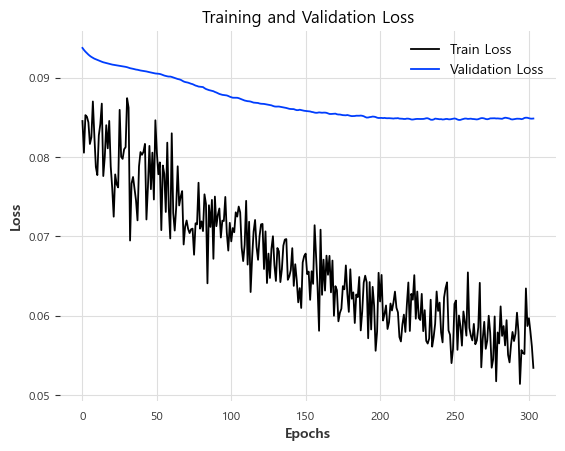

In [11]:
# 학습 및 검증 손실 시각화
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [12]:
# train column중 train/산지/도매 데이터와 관련된 column끼리 분리
train_cols = []
train_sanji_cols = []
train_dome_cols = []
for col in train.columns:
    if '산지' in col:
        train_sanji_cols.append(col)
    elif '도매' in col:
        train_dome_cols.append(col)
    else:
        train_cols.append(col)
print('train.csv :', len(train_cols))
print('train 산지 :', len(train_sanji_cols))
print('train 도매 :', len(train_dome_cols))

train.csv : 129
train 산지 : 12
train 도매 : 0


In [13]:
sub = pd.read_csv('data/sample_submission.csv')

for i in range(25): ## TEST_00 ~ TEST_24
    print(i, end =' ')

    file = test_paths[i]
    sanji_file = test_sanji_paths[i]
    dome_file = test_dome_paths[i]

    test_num = file.split("\\")[-1].split(".")[0]
    num = test_num.split('_')[-1]

    # test.csv, train 데이터와 형식 맞춰주기
    test = pd.read_csv(file)
    test = basic_preprocess_train(test, apple = True)
    test = gen_transpose_test(test, train_cols)

    # test 산지
    test_sanji = pd.read_csv(sanji_file)
    # print(test_sanji)
    test_sanji = gen_transpose_test_sanji(test_sanji, train_sanji_cols)
    # print(test_sanji)


    # test 도매
    # test_dome = pd.read_csv(dome_file)
    # test_dome = gen_transpose_test_dome(test_dome, train_dome_cols)

    # 전체 test 데이터로 concat
    test = pd.concat([test, test_sanji], axis = 1)
    test = test[train.columns]
    # 결측치 존재하는지 확인
    test_null_check = test.isnull().sum()
    for i in test_null_check.index:
        if test_null_check[i]!=0:
            print(i, test_null_check[i])
    
    for j in range(3):
        test_j = test[7+j:]
        test_scaled = scaler.transform(TimeSeries.from_dataframe(test_j))

        # TSMixer 모델로 예측 수행
        predictions_test = tsmixer_model.predict(n=output_chunk_length, series=test_scaled)

        # 예측 결과를 Pandas DataFrame으로 변환
        predictions_rescaled_test = scaler.inverse_transform(predictions_test).pd_dataframe()
        test = pd.concat([test, predictions_rescaled_test], axis = 0).reset_index(drop = True)
        for col in test.columns:
            id, price = col.split("__")
            if (id in target_id) and (price == '평균가격(원)'):
                sub.loc[sub['시점'] == test_num + f'+{j+1}순', id.split('_')[0]] = predictions_rescaled_test.loc[list(predictions_rescaled_test.index)[0], col]

sub

0 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 220.28it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 246.42it/s]
1 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 282.44it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.94it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 217.52it/s]
2 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.19it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.78it/s] 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.69it/s] 
3 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.01it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.32it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.07it/s]
4 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.17it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.19it/s]
5 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.93it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.42it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 221.23it/s]
6 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 218.93it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.05it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.04it/s]
7 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 224.97it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 227.59it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.97it/s]
8 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 221.56it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.41it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.17it/s]
9 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 220.74it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 205.18it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.08it/s]
10 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 208.72it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 203.63it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.06it/s]
11 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 219.13it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.94it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.47it/s]
12 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.56it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.53it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 216.27it/s]
13 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.16it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.07it/s]
14 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 175.15it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 215.68it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 168.31it/s]
15 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 227.54it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 285.97it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 236.95it/s]
16 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.96it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.62it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 331.51it/s]
17 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 305.26it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 285.27it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.57it/s]
18 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.40it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.00it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.92it/s]
19 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.32it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 212.60it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 230.34it/s]
20 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.02it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.87it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.87it/s]
21 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.63it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 178.72it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 203.04it/s]
22 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 198.34it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 286.18it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 207.34it/s]
23 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 215.37it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.66it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.69it/s]
24 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 233.20it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 271.11it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 224.38it/s]


,시점,감자,건고추,깐마늘(국산),대파,무,배추,사과,상추,양파,배
0,TEST_00+1순,37145.908411,670561.497590,169845.068501,1932.835336,32710.010306,16938.155856,23641.248368,1152.534001,1445.743778,32338.267493
1,TEST_00+2순,36854.527163,672749.231525,167776.259283,1927.690408,32883.550943,16931.622619,23665.028555,1170.169770,1422.496233,31628.095859
2,TEST_00+3순,37262.944774,669163.656655,168938.255349,1935.774045,32773.765810,16886.326781,23635.837322,1153.652235,1408.722735,32133.647869
3,TEST_01+1순,40159.026179,653145.040038,167201.043565,1786.219359,13777.685282,6262.462647,23199.523596,995.842368,1488.191474,26552.456645
4,TEST_01+2순,40622.315838,649803.552620,167473.432761,1843.879288,13738.985893,6006.743764,23059.596610,969.709005,1487.050301,25845.076786
...,...,...,...,...,...,...,...,...,...,...,...
70,TEST_23+2순,41202.357234,636688.958128,167388.145126,1742.768555,9116.101810,4821.908331,22229.644257,872.336913,1431.602916,25731.592222
71,TEST_23+3순,41035.156568,636285.106827,167481.656413,1736.106743,9131.351671,4774.095401,22227.424180,861.392081,1434.863443,25625.654843
72,TEST_24+1순,47348.813456,543183.017852,174191.024442,1298.440647,13618.792140,8759.423994,28588.619694,993.824149,505.312612,38314.465763
73,TEST_24+2순,54029.131266,542759.054352,174400.351477,1324.978187,13519.057457,8815.923145,28354.633823,985.957030,545.045725,38396.646467


In [14]:
sub.describe()

,감자,건고추,깐마늘(국산),대파,무,배추,사과,상추,양파,배
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,43791.836377,579795.050284,172434.593419,1648.466595,17438.410957,11701.812871,27361.340902,1381.716859,1163.161669,36342.335604
std,11899.117085,48257.601817,3579.935710,286.189767,6392.115316,4704.302350,2869.641096,542.725733,396.607237,5294.987062
min,30629.824472,539925.883131,167088.739601,1117.376142,9116.101810,4774.095401,22227.424180,861.392081,371.812922,25449.009354
25%,36217.472657,543844.002788,168429.583605,1479.792008,13449.072423,8757.799508,23667.988615,984.295681,720.229711,35736.571600
50%,38982.947948,551866.379852,173796.764191,1721.770117,14784.016565,10028.508659,28293.840449,1099.358510,1363.379999,38396.646467
75%,44275.811910,636234.138189,175000.322470,1858.759513,21850.787114,16806.761051,29625.616111,1953.305118,1438.347461,39806.828166
max,72195.353867,672749.231525,177252.911629,2133.873996,32883.550943,24202.092868,32047.000481,2559.815868,1535.084417,41513.015802


In [15]:
sub.to_csv('submission/20.csv', index = False)